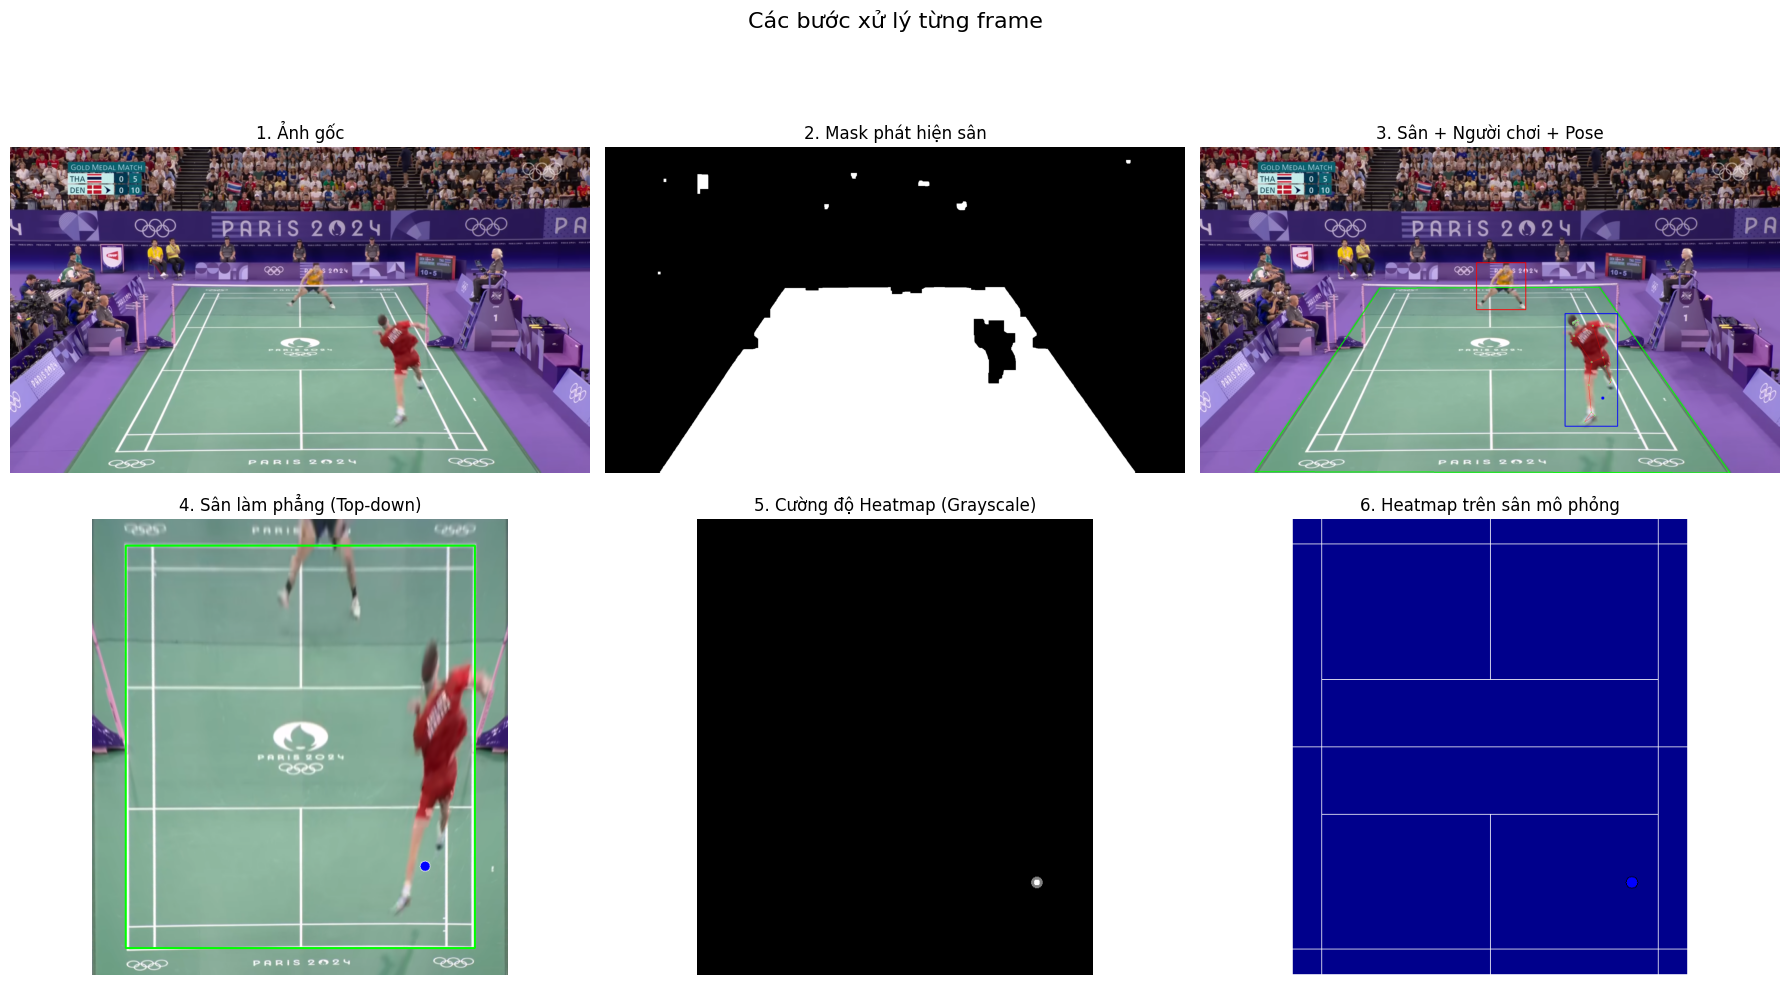

In [3]:
import cv2
import numpy as np
import time
from ultralytics import YOLO
import mediapipe as mp
import matplotlib.pyplot as plt
# Thêm import cần thiết cho việc tạo NormalizedLandmarkList
from mediapipe.framework.formats import landmark_pb2

# --- Khởi tạo MediaPipe Pose ---
mp_pose = mp.solutions.pose
pose_detector = mp_pose.Pose(static_image_mode=True, # Chuyển sang static_image_mode=True cho ảnh đơn
                             model_complexity=1,
                             smooth_landmarks=True,
                             enable_segmentation=False,
                             min_detection_confidence=0.5,
                             min_tracking_confidence=0.5)

# --- Các hàm phụ trợ 
def sort_corners(pts_array):
    if not isinstance(pts_array, np.ndarray): pts_array = np.array(pts_array)
    if pts_array.ndim == 3: pts_array = pts_array.reshape(-1, 2)
    if pts_array.shape[0] != 4: return None
    rect = np.zeros((4, 2), dtype="float32")
    s = pts_array.sum(axis=1)
    rect[0], rect[2] = pts_array[np.argmin(s)], pts_array[np.argmax(s)]
    idx_tl, idx_br = np.argmin(s), np.argmax(s)
    remaining_indices = [i for i in range(4) if i not in [idx_tl, idx_br]]
    if len(remaining_indices) == 2:
        pt1, pt2 = pts_array[remaining_indices[0]], pts_array[remaining_indices[1]]
        if pt1[1] < pt2[1]: rect[1], rect[3] = pt1, pt2
        elif pt2[1] < pt1[1]: rect[1], rect[3] = pt2, pt1
        else: rect[1], rect[3] = (pt1, pt2) if pt1[0] > pt2[0] else (pt2, pt1)
    else: return None
    return rect.astype(np.int32)

def is_point_in_box(px, py, x1, y1, x2, y2, tol=0):
    return (x1 - tol <= px <= x2 + tol and y1 - tol <= py <= y2 + tol)

def is_box_intersecting_polygon(box, polygon_pts):
    x1, y1, x2, y2 = box
    box_poly_pts = np.array([[x1,y1],[x2,y1],[x2,y2],[x1,y2]], dtype=np.float32)
    if polygon_pts.ndim == 2: poly_cv = polygon_pts.reshape(-1,1,2).astype(np.float32)
    elif polygon_pts.ndim == 3 and polygon_pts.shape[1]==1 and polygon_pts.shape[2]==2: poly_cv = polygon_pts.astype(np.float32)
    else: return False
    for pt in box_poly_pts:
        if cv2.pointPolygonTest(poly_cv, (float(pt[0]), float(pt[1])), False) >= 0: return True
    for pt in poly_cv.reshape(-1,2):
        if x1 <= pt[0] <= x2 and y1 <= pt[1] <= y2: return True
    return False

def draw_badminton_court_lines(image, W, H, color=(255, 255, 255), thickness=1):
    if W <= 0 or H <= 0: return
    cv2.rectangle(image, (0, 0), (W - 1, H - 1), color, thickness)
    cv2.line(image, (0, H // 2), (W - 1, H // 2), color, thickness)
    single_line_offset_x = int((0.46 / 6.1) * W)
    cv2.line(image, (single_line_offset_x, 0), (single_line_offset_x, H - 1), color, thickness)
    cv2.line(image, (W - 1 - single_line_offset_x, 0), (W - 1 - single_line_offset_x, H - 1), color, thickness)
    short_service_line_offset_y = int((1.98 / 13.4) * H)
    y_ssl_top = H // 2 - short_service_line_offset_y
    y_ssl_bottom = H // 2 + short_service_line_offset_y
    cv2.line(image, (single_line_offset_x, y_ssl_top), (W - 1 - single_line_offset_x, y_ssl_top), color, thickness)
    cv2.line(image, (single_line_offset_x, y_ssl_bottom), (W - 1 - single_line_offset_x, y_ssl_bottom), color, thickness)
    cv2.line(image, (W // 2, y_ssl_top), (W // 2, 0), color, thickness)
    cv2.line(image, (W // 2, y_ssl_bottom), (W // 2, H - 1), color, thickness)
    long_service_line_doubles_offset_y = int((0.76 / 13.4) * H)
    y_lsld_top = long_service_line_doubles_offset_y
    y_lsld_bottom = H - 1 - long_service_line_doubles_offset_y
    cv2.line(image, (0, y_lsld_top), (W - 1, y_lsld_top), color, thickness)
    cv2.line(image, (0, y_lsld_bottom), (W - 1, y_lsld_bottom), color, thickness)

mp_drawing = mp.solutions.drawing_utils

def process_and_plot_single_image(image_path):
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Lỗi: Không thể đọc ảnh từ '{image_path}'")
        return

    model = YOLO("yolov8n.pt")


    dest_rect_width = 610
    dest_rect_height = int(dest_rect_width * (67.1 / 61.0))
    dest_rect_corners_dst = np.array([
        [[0,0]],[[dest_rect_width-1,0]],
        [[dest_rect_width-1,dest_rect_height-1]],[[0,dest_rect_height-1]]], dtype=np.float32)

    clahe_heatmap = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_video = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    default_warped_display = np.zeros((dest_rect_height, dest_rect_width, 3), dtype=np.uint8)
    default_schematic_display_width = 300
    default_schematic_display_height = int(300 * (13.4/6.1))
    default_schematic_court_img = np.zeros((default_schematic_display_height, default_schematic_display_width, 3), dtype=np.uint8)
    draw_badminton_court_lines(default_schematic_court_img, default_schematic_display_width, default_schematic_display_height, (70,70,70), 1)
    cv2.putText(default_schematic_court_img, "No schematic data", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (220,220,220), 1)

    all_schematic_positions_history = []

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Các bước xử lý từng frame", fontsize=16)
    plot_idx_counter = 0 # Sử dụng biến đếm riêng cho subplot

    def display_plt_image(ax_ref, img_data, title_text):
        nonlocal plot_idx_counter
        current_ax = axs[plot_idx_counter // 3, plot_idx_counter % 3]
        plot_idx_counter +=1

        if img_data is None:
            current_ax.text(0.5, 0.5, 'Ảnh không có sẵn', horizontalalignment='center', verticalalignment='center')
            current_ax.set_title(title_text)
            current_ax.axis('off')
            return
        if len(img_data.shape) == 2:
            current_ax.imshow(img_data, cmap='gray')
        else:
            current_ax.imshow(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB))
        current_ax.set_title(title_text)
        current_ax.axis('off')

    display_frame_step1 = frame.copy()
    display_plt_image(axs, display_frame_step1, "1. Ảnh gốc")

    display_frame_court_players_pose = frame.copy()

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    h, s, v_channel = cv2.split(hsv) # Đổi tên biến v để tránh xung đột
    v_enh = clahe_video.apply(v_channel)
    hsv_enh = cv2.merge([h, s, v_enh])
    mask_court_detection = cv2.inRange(hsv_enh, np.array([30,30,30]), np.array([90,255,255]))
    mask_court_detection = cv2.morphologyEx(mask_court_detection, cv2.MORPH_OPEN, np.ones((5,5),np.uint8), iterations=2)
    mask_court_detection = cv2.morphologyEx(mask_court_detection, cv2.MORPH_CLOSE, np.ones((11,11),np.uint8), iterations=3)

    display_plt_image(axs, mask_court_detection, "2. Mask phát hiện sân")

    contours, _ = cv2.findContours(mask_court_detection, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_roi_corners = None
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        if cv2.contourArea(cnt) > 0.005 * frame.shape[0] * frame.shape[1]:
            poly = cv2.approxPolyDP(cnt, 0.025 * cv2.arcLength(cnt, True), True)
            if len(poly) == 4:
                final_roi_corners = sort_corners(poly)

    if final_roi_corners is not None:
        cv2.polylines(display_frame_court_players_pose, [final_roi_corners.reshape(-1,1,2)], True, (0,255,0), 2)

    players_on_court, player_midpoints_original_with_color = [], []
    player_transformed_points_with_color = []

    schematic_w_actual = default_schematic_display_width
    schematic_h_actual = default_schematic_display_height
    limit_x1_w, limit_y1_w = 0,0
    limit_x2_w, limit_y2_w = schematic_w_actual, schematic_h_actual
    H_matrix = None
    warped_display = default_warped_display.copy()

    if final_roi_corners is not None and final_roi_corners.shape == (4,2):
        yolo_res = model(frame, classes=[0], verbose=False)
        persons = []
        for res_item in yolo_res: # Đổi tên biến
            for box_obj in res_item.boxes:
                b = box_obj.xyxy[0].cpu().numpy().astype(int)
                if is_box_intersecting_polygon(b, final_roi_corners):
                    persons.append({'box':b, 'area':(b[2]-b[0])*(b[3]-b[1])})
        players_on_court = sorted(persons, key=lambda x: x['area'], reverse=True)[:2]
        player_colors = [(255,0,0), (0,0,255)] # Đổi tên biến

        for i, p_data in enumerate(players_on_court):
            x1_p,y1_p,x2_p,y2_p = p_data['box']
            cv2.rectangle(display_frame_court_players_pose, (x1_p,y1_p), (x2_p,y2_p), player_colors[i], 2)
            roi_img = frame[y1_p:y2_p, x1_p:x2_p]
            if roi_img.size == 0: continue

            roi_rgb = cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB)
            pose_res = pose_detector.process(roi_rgb)

            if pose_res.pose_landmarks:
                # Tạo một NormalizedLandmarkList mới để chứa các landmark đã được điều chỉnh tọa độ
                # và chuẩn hóa theo kích thước của display_frame_court_players_pose
                adjusted_landmark_list = landmark_pb2.NormalizedLandmarkList()
                
                h_main_img, w_main_img, _ = display_frame_court_players_pose.shape
                h_roi, w_roi, _ = roi_img.shape

                for lm_original in pose_res.pose_landmarks.landmark:
                    # Chuyển tọa độ landmark từ ROI về tọa độ tuyệt đối trên ảnh gốc
                    abs_x_on_roi = lm_original.x * w_roi
                    abs_y_on_roi = lm_original.y * h_roi
                    
                    abs_x_on_main = abs_x_on_roi + x1_p
                    abs_y_on_main = abs_y_on_roi + y1_p

                    # Thêm landmark mới đã chuẩn hóa theo ảnh gốc vào danh sách
                    new_lm = adjusted_landmark_list.landmark.add()
                    new_lm.x = abs_x_on_main / w_main_img
                    new_lm.y = abs_y_on_main / h_main_img
                    new_lm.z = lm_original.z 
                    if lm_original.HasField('visibility'):
                         new_lm.visibility = lm_original.visibility
                
                mp_drawing.draw_landmarks(
                    image=display_frame_court_players_pose, # Vẽ lên ảnh chính
                    landmark_list=adjusted_landmark_list,   # Dùng danh sách landmark đã điều chỉnh
                    connections=mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0), thickness=1, circle_radius=2),
                    connection_drawing_spec=mp_drawing.DrawingSpec(color=(0,0,255), thickness=1)
                )

                # Logic tính toán điểm giữa gót chân vẫn dùng landmark gốc (chuẩn hóa theo ROI)
                lm_calc = pose_res.pose_landmarks.landmark
                try:
                    lh = lm_calc[mp_pose.PoseLandmark.LEFT_HEEL.value]
                    rh = lm_calc[mp_pose.PoseLandmark.RIGHT_HEEL.value]
                    if lh.visibility > 0.5 and rh.visibility > 0.5:
                        # Tọa độ lx_f, ly_f, rx_f, ry_f là tọa độ tuyệt đối trên ảnh gốc
                        lx_f, ly_f = int(lh.x * w_roi) + x1_p, int(lh.y * h_roi) + y1_p
                        rx_f, ry_f = int(rh.x * w_roi) + x1_p, int(rh.y * h_roi) + y1_p
                        tol = int(0.05*min(x2_p-x1_p,y2_p-y1_p))
                        if is_point_in_box(lx_f,ly_f,x1_p,y1_p,x2_p,y2_p,tol) and \
                           is_point_in_box(rx_f,ry_f,x1_p,y1_p,x2_p,y2_p,tol):
                            mid_x, mid_y = int((lx_f+rx_f)/2), int((ly_f+ry_f)/2)
                            player_midpoints_original_with_color.append(((mid_x,mid_y), player_colors[i]))
                            cv2.circle(display_frame_court_players_pose, (mid_x,mid_y), 5, player_colors[i], -1)
                except (IndexError, Exception): pass
        
        try:
            H_matrix_cand, _ = cv2.findHomography(final_roi_corners.astype(np.float32), dest_rect_corners_dst)
            if H_matrix_cand is not None and H_matrix_cand.shape == (3,3):
                H_matrix = H_matrix_cand
                warped_display = cv2.warpPerspective(frame, H_matrix, (dest_rect_width, dest_rect_height))
                
                h_w_display, w_w_display = dest_rect_height, dest_rect_width
                off_x_r, off_y_r = 0.081, 0.06
                limit_x1_w_calc = int(w_w_display*off_x_r)
                limit_y1_w_calc = int(h_w_display*off_y_r)
                limit_x2_w_calc = w_w_display-int(w_w_display*off_x_r)
                limit_y2_w_calc = h_w_display-int(h_w_display*off_y_r)

                limit_x1_w, limit_y1_w = limit_x1_w_calc, limit_y1_w_calc
                limit_x2_w, limit_y2_w = limit_x2_w_calc, limit_y2_w_calc
                schematic_w_actual = limit_x2_w - limit_x1_w
                schematic_h_actual = limit_y2_w - limit_y1_w
                
                # draw_badminton_court_lines(warped_display, dest_rect_width, dest_rect_height, color=(255,255,0), thickness=2)
                cv2.rectangle(warped_display, (limit_x1_w,limit_y1_w), (limit_x2_w,limit_y2_w), (0,255,0),2)

                if player_midpoints_original_with_color and H_matrix is not None:
                    pts_orig = np.array([[list(d[0]) for d in player_midpoints_original_with_color]], dtype=np.float32)
                    pts_trans = cv2.perspectiveTransform(pts_orig, H_matrix)
                    if pts_trans is not None:
                        for i_pt, (orig_data, trans_pt) in enumerate(zip(player_midpoints_original_with_color, pts_trans[0])):
                            color_loop = orig_data[1]
                            tx, ty = int(trans_pt[0]), int(trans_pt[1])
                            
                            if 0 <= tx < w_w_display and 0 <= ty < h_w_display:
                                cv2.circle(warped_display, (tx,ty),7,color_loop,-1); cv2.circle(warped_display,(tx,ty),8,(255,255,255),1)
                            
                            if limit_x1_w <= tx < limit_x2_w and limit_y1_w <= ty < limit_y2_w:
                                player_transformed_points_with_color.append(((tx,ty), color_loop))
                                schematic_px = tx - limit_x1_w
                                schematic_py = ty - limit_y1_w
                                if schematic_w_actual > 0 and schematic_h_actual > 0 and \
                                   0 <= schematic_px < schematic_w_actual and \
                                   0 <= schematic_py < schematic_h_actual:
                                    all_schematic_positions_history.append((schematic_px, schematic_py))
        except Exception: H_matrix = None

    display_plt_image(axs, display_frame_court_players_pose, "3. Sân + Người chơi + Pose")
    display_plt_image(axs, warped_display, "4. Sân làm phẳng (Top-down)")
    
    heatmap_intensity_for_plot = None
    if H_matrix is not None and schematic_w_actual > 0 and schematic_h_actual > 0:
        current_heatmap_base_color = np.zeros((schematic_h_actual, schematic_w_actual, 3), dtype=np.uint8)
        if all_schematic_positions_history:
            # Logic heatmap pixel-level như code gốc bạn cung cấp cho ảnh đơn
            heatmap_accumulator = np.zeros((schematic_h_actual, schematic_w_actual), dtype=np.float32)
            for hx, hy in all_schematic_positions_history:
                if 0 <= hx < schematic_w_actual and 0 <= hy < schematic_h_actual: # Kiểm tra biên
                    heatmap_accumulator[int(hy), int(hx)] += 1 # Đảm bảo hy, hx là int cho chỉ số mảng

            if np.max(heatmap_accumulator) > 0:
                heatmap_normalized = (heatmap_accumulator / np.max(heatmap_accumulator) * 255).astype(np.uint8)
                heatmap_enhanced = clahe_heatmap.apply(heatmap_normalized)
                # Tăng blur một chút cho ảnh đơn để dễ thấy hơn
                heatmap_blurred = cv2.GaussianBlur(heatmap_enhanced, (25, 25), 0) 
                
                heatmap_intensity_for_plot = heatmap_blurred.copy()
                current_heatmap_base_color = cv2.applyColorMap(heatmap_blurred, cv2.COLORMAP_JET)
        
        draw_badminton_court_lines(current_heatmap_base_color, schematic_w_actual, schematic_h_actual, color=(255,255,255), thickness=1)
        for transformed_pt_data in player_transformed_points_with_color:
            (tx, ty), player_color = transformed_pt_data 
            pt_x_on_schematic = tx - limit_x1_w
            pt_y_on_schematic = ty - limit_y1_w
            if 0 <= pt_x_on_schematic < schematic_w_actual and 0 <= pt_y_on_schematic < schematic_h_actual:
                cv2.circle(current_heatmap_base_color, (int(pt_x_on_schematic), int(pt_y_on_schematic)), 7, player_color, -1)
                cv2.circle(current_heatmap_base_color, (int(pt_x_on_schematic), int(pt_y_on_schematic)), 8, (0,0,0), 1)
        schematic_court_img_final = current_heatmap_base_color
    else:
        schematic_court_img_final = default_schematic_court_img.copy()

    display_plt_image(axs, heatmap_intensity_for_plot, "5. Cường độ Heatmap (Grayscale)")
    display_plt_image(axs, schematic_court_img_final, "6. Heatmap trên sân mô phỏng")

    for i in range(plot_idx_counter, 2 * 3): # Ẩn các subplot thừa nếu có
         fig.delaxes(axs[i // 3, i % 3])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    pose_detector.close()


if __name__ == '__main__':
    image_file_path = 'demo1.png'
    try:
        with open(image_file_path,'rb') as f:pass
        process_and_plot_single_image(image_file_path)
    except FileNotFoundError: print(f"LỖI: Không tìm thấy file '{image_file_path}'.")
    except Exception as e: print(f"Lỗi không mong muốn: {e}")